In [3]:
from dotenv import load_dotenv

load_dotenv()
# OR, the same with increased verbosity
load_dotenv(verbose=True)
# OR, explicitly providing path to '.env'
from pathlib import Path  # Python 3.6+ only

env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [52]:
%matplotlib inline
from pymongo import MongoClient
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

mongo_cluster = MongoClient(os.environ['MONGO_URI']).iss

In [29]:
db = mongo_cluster.down_epochs_res
EPOCHS = [20, 30, 40, 50, 100]

acc = [
    [j['predicted'] for j in db.find({'downstream_epochs': i}, {'predicted': 1})] for i in EPOCHS
]

acc = np.array(acc)
acc_mean = np.mean(acc, axis=1)

df = pd.DataFrame()
df['epochs'] = EPOCHS
df['acc mean %'] = acc_mean / 256 * 100  #total test images
df

,epochs,acc mean %
0,20,22.031250
1,30,37.421875
2,40,41.015625
3,50,44.531250
4,100,41.406250


In [30]:
res_db = mongo_cluster.results2

transfer_res = [i for i in res_db.find({'model_type': 'eff_net_frozen'})]

transfer_predicted = np.array(
    [i['predicted'] for i in transfer_res]
).mean()
transfer_miss = np.array(
    [i['miss_classified'] for i in transfer_res]
).mean()
transfer_epsilon = np.array(
    [i['epsilon_mean'] for i in transfer_res]
).mean()
transfer_total_images = np.array(
    [i['total_test_images'] for i in transfer_res]
).mean()

transfer_accuracy = np.round(transfer_predicted / transfer_total_images * 100, 3)
transfer_miss_rate = np.round(transfer_miss / transfer_predicted * 100, 3)
transfer_epsilon = np.round(transfer_epsilon, 3)
print(
    f'EffNet in transfer learning -> accuracy = {transfer_accuracy}%, miss rate = {transfer_miss_rate}%, epsilon mean = {transfer_epsilon}')

EffNet in transfer learning -> accuracy = 65.156%, miss rate = 94.245%, epsilon mean = 0.024


In [19]:
no_pr_res = [i for i in res_db.find({'model_type': 'efficientnetb0', 'pretext_task': {'$exists': False}})]

no_pr_predicted = np.array(
    [i['predicted'] for i in no_pr_res]
).mean()
no_pr_miss = np.array(
    [i['miss_classified'] for i in no_pr_res]
).mean()
no_pr_epsilon = np.array(
    [i['epsilon_mean'] for i in no_pr_res]
).mean()
no_pr_total_images = np.array(
    [i['total_test_images'] for i in no_pr_res]
).mean()

no_pr_accuracy = np.round(no_pr_predicted / no_pr_total_images * 100, 3)
no_pr_miss_rate = np.round(no_pr_miss / no_pr_predicted * 100, 3)
no_pr_epsilon = np.round(no_pr_epsilon, 3)
print(
    f'EffNet with no pretext task -> accuracy = {no_pr_accuracy}%, miss rate = {no_pr_miss_rate}%, epsilon mean = {no_pr_epsilon}')

EffNet with no pretext task -> accuracy = 39.922%, miss rate = 99.413%, epsilon mean = 0.011


In [31]:
PR_EPOCHS = [25, 50, 75, 100]

jigsaw_predicted = []
jigsaw_miss = []
jigsaw_epsilon = []
jigsaw_total_images = []

for pe in PR_EPOCHS:
    jigsaw_res = [i for i in res_db.find({
        'model_type': 'efficientnetb0',
        'pretext_task': 'jigsaw',
        'pretext_epochs': pe
    })]

    jigsaw_predicted.append(np.array(
        [i['predicted'] for i in jigsaw_res]
    ).mean())
    jigsaw_miss.append(np.array(
        [i['miss_classified'] for i in jigsaw_res]
    ).mean())
    jigsaw_epsilon.append(np.array(
        [i['epsilon_mean'] for i in jigsaw_res]
    ).mean())
    jigsaw_total_images.append(np.array(
        [i['total_test_images'] for i in jigsaw_res]
    ).mean())

jigsaw_accuracy = np.round(np.array(jigsaw_predicted) / np.array(jigsaw_total_images) * 100, 3)
jigsaw_miss_rate = np.round(np.array(jigsaw_miss) / np.array(jigsaw_predicted) * 100, 3)
jigsaw_epsilon = np.round(jigsaw_epsilon, 3)

jigsaw_df = pd.DataFrame()
jigsaw_df['pretext epochs'] = PR_EPOCHS
jigsaw_df['accuracy %'] = jigsaw_accuracy
jigsaw_df['miss classification rate'] = jigsaw_miss_rate
jigsaw_df['epsilon mean'] = jigsaw_epsilon
jigsaw_df

,pretext epochs,accuracy %,miss classification rate,epsilon mean
0,25,43.984,95.915,0.012
1,50,43.438,97.482,0.011
2,75,43.281,93.141,0.013
3,100,42.188,95.000,0.012


In [69]:
rotation_predicted = []
rotation_miss = []
rotation_epsilon = []
rotation_total_images = []

for pe in PR_EPOCHS:
    rotation_res = [i for i in res_db.find({
        'model_type': 'efficientnetb0',
        'pretext_task': 'rotation',
        'pretext_epochs': pe
    })]

    rotation_predicted.append(np.array(
        [i['predicted'] for i in rotation_res]
    ).mean())
    rotation_miss.append(np.array(
        [i['miss_classified'] for i in rotation_res]
    ).mean())
    rotation_epsilon.append(np.array(
        [i['epsilon_mean'] for i in rotation_res]
    ).mean())
    rotation_total_images.append(np.array(
        [i['total_test_images'] for i in rotation_res]
    ).mean())

rotation_accuracy = np.round(np.array(rotation_predicted) / np.array(rotation_total_images) * 100, 3)
rotation_miss_rate = np.round(np.array(rotation_miss) / np.array(rotation_predicted) * 100, 3)
rotation_epsilon = np.round(rotation_epsilon, 3)

rotation_df = pd.DataFrame()
rotation_df['pretext epochs'] = PR_EPOCHS
rotation_df['accuracy %'] = rotation_accuracy
rotation_df['miss classification rate'] = rotation_miss_rate
rotation_df['epsilon mean'] = rotation_epsilon
rotation_df

,pretext epochs,accuracy %,miss classification rate,epsilon mean
0,25,44.219,96.643,0.012
1,50,44.141,97.876,0.012
2,75,46.953,95.674,0.012
3,100,44.531,97.544,0.012


In [ ]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

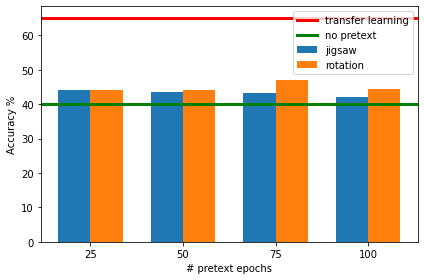

In [68]:
x = np.arange(len(PR_EPOCHS))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, jigsaw_accuracy, width)
rects2 = ax.bar(x + width/2, rotation_accuracy, width)
plt.axhline(y=transfer_accuracy, color='r', linestyle='-', linewidth=3)
plt.axhline(y=no_pr_accuracy, color='g', linestyle='-', linewidth=3)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy %')
ax.set_xlabel('# pretext epochs')
ax.set_xticks(x)
ax.set_xticklabels(PR_EPOCHS)
ax.legend(['transfer learning', 'no pretext', 'jigsaw', 'rotation'])
#autolabel(rects1)
#autolabel(rects2)
fig.tight_layout()

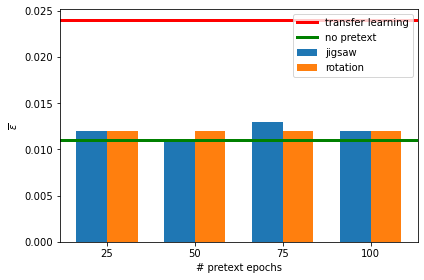

In [70]:
fig1, ax1 = plt.subplots()
rects3 = ax1.bar(x - width/2, jigsaw_epsilon, width)
rects4 = ax1.bar(x + width/2, rotation_epsilon, width)
plt.axhline(y=transfer_epsilon, color='r', linestyle='-', linewidth=3)
plt.axhline(y=no_pr_epsilon, color='g', linestyle='-', linewidth=3)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('$\overline{\epsilon}$')
ax1.set_xlabel('# pretext epochs')
ax1.set_xticks(x)
ax1.set_xticklabels(PR_EPOCHS)
ax1.legend(['transfer learning', 'no pretext', 'jigsaw', 'rotation'])
#autolabel(rects1)
#autolabel(rects2)
fig1.tight_layout()

In [71]:
best_res_df = pd.DataFrame()
best_res_df['pre text task / pre training'] = ['ImageNet classification', 'None', 'rotation', 'jigsaw']
best_res_df['accuracy'] = [65, 39, 47, 43]
best_res_df['epsilon'] = [0.024, 0.011, 0.012, 0.013]
best_res_df

,pre text task / pre training,accuracy,epsilon
0,ImageNet classification,65,0.024
1,None,39,0.011
2,rotation,47,0.012
3,jigsaw,43,0.013
